Добавление индикатора   

In [1]:
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize']=(15,7) # set the figure size

Backtrader делает создание индикаторов удобным, предоставляя базовые классы и функции. Индикатор будет наследоваться от bt.Indicator и переопределять методы __init__ для инициализации и next для логики вычисления на каждом шаге (если это необходимо).

In [8]:
class MyIndicator(bt.Indicator):
    lines = ('diff',)  # Определяем линии, которые будут использоваться индикатором

    def __init__(self, period_short=10, period_long=20):
        # Создание скользящих средних
        sma_short = bt.indicators.SimpleMovingAverage(self.data, period=period_short)
        sma_long = bt.indicators.SimpleMovingAverage(self.data, period=period_long)
        self.lines.diff = sma_short - sma_long  # Вычисление разницы между скользящими средними

Теперь, когда индикатор определен, его можно интегрировать в стратегию. Добавьте создание экземпляра индикатора в метод __init__ вашей стратегии и используйте его значения в методе next для принятия торговых решений.

In [9]:
class SmaCrossStrategy(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=20) # Создание скользящих средних
        self.my_indicator = MyIndicator(period_short=10, period_long=20) # Создание индикатора
    
    def next(self):
        if self.my_indicator.lines.diff[0] > 0:
            # Логика покупки, если разница положительная (короткая SMA выше длинной)
            if not self.position:
                self.buy()
        elif self.my_indicator.lines.diff[0] < 0:
            # Логика продажи, если разница отрицательная (короткая SMA ниже длинной)
            if not self.position:
                self.sell()

Индикаторы в Backtrader, как правило, вычисляются в методе __init__ класса индикатора. Это позволяет Backtrader автоматически обновлять значения индикатора на каждом шаге (на каждом баре данных). Вам не нужно вручную вызывать вычисления в методе next; Backtrader сделает это за вас, и вы сможете доступиться к текущим и предыдущим значениям индикатора через его атрибуты.

Использование метода __init__ для определения логики индикатора является предпочтительным, потому что это обеспечивает автоматическое управление временными рядами и значениями индикатора в рамках фреймворка Backtrader. Вам не нужно беспокоиться о обновлении значений на каждом шаге; Backtrader делает это за вас, опираясь на ваши определения в __init__. Вы просто обращаетесь к текущим или предыдущим значениям в методе next вашей стратегии для принятия решений.

Таким образом, создав индикатор, вы можете использовать его в любом количестве стратегий, просто добавив его в метод __init__ стратегии и используя его значения в методе next или в любых других методах вашей стратегии для анализа рынка и принятия торговых решений.

Этот подход делает код более модульным, улучшает повторное использование кода и упрощает тестирование различных стратегий с использованием разных индикаторов, не меняя их базовую логику. Backtrader разработан таким образом, чтобы облегчить работу с временными рядами и индикаторами, делая процесс создания, тестирования и оптимизации торговых стратегий максимально простым и эффективным.

Final Portfolio Value: 1,000.00
P/L: -0.00


<IPython.core.display.Javascript object>

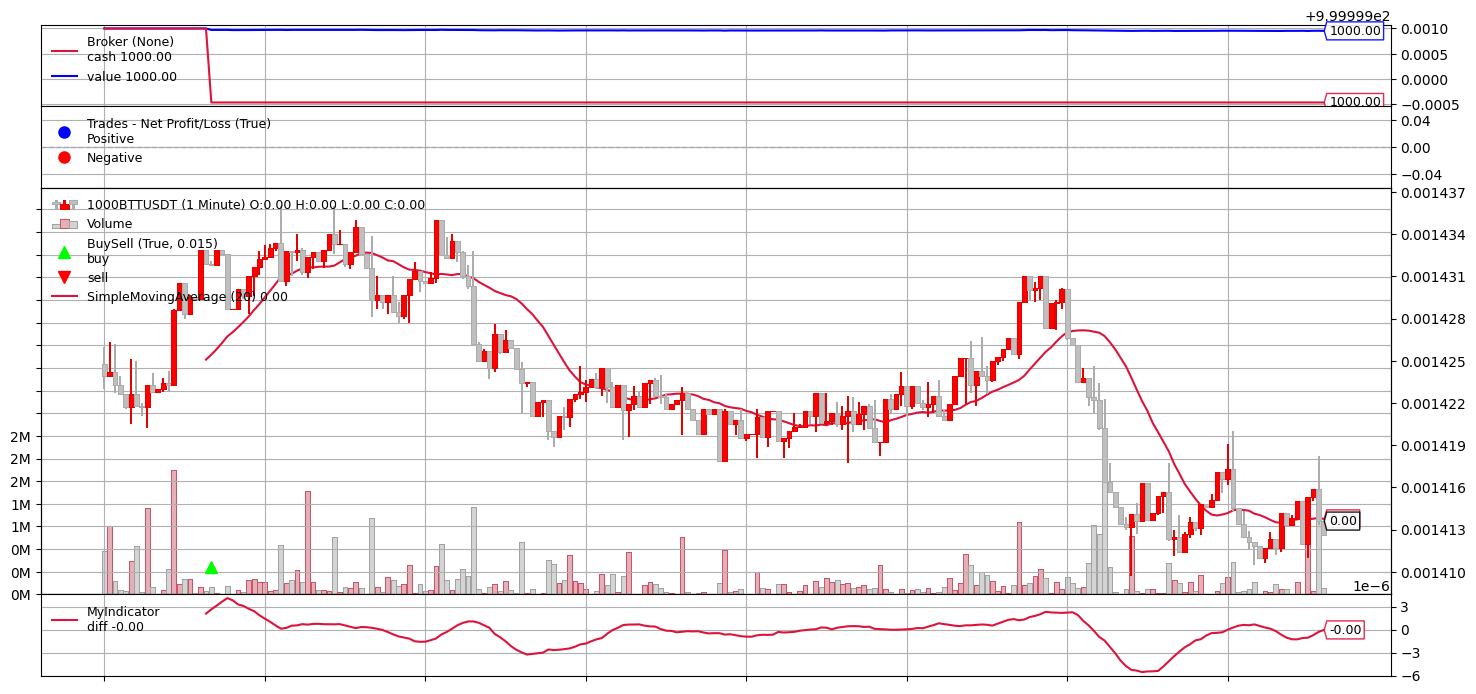

In [12]:
# Создание и настройка Backtrader
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCrossStrategy)

# Загрузка данных
data = bt.feeds.GenericCSVData(
    dataname='data/1000BTTUSDT.csv',
    datetime=0,
    time = -1,
    open=1,
    high=2,
    low=3,
    close=4,
    volume=5,
    openinterest = -1,
    dtformat=('%m/%d/%Y %H:%M'),
    timeframe=bt.TimeFrame.Minutes,
    nullvalue=0.0,
    header=True,
)

cerebro.adddata(data)

# Настройка начального капитала
startcash = 1000.0
cerebro.broker.setcash(startcash)
# --------------------------------------------------------------------
# Комиссия брокера 2% от суммы сделки
cerebro.broker.setcommission(0.02)

# Для акций может потребоваться фиксированная комиссия за сделку
# cerebro.broker.setcommission(commission=0.01, pername=True)

# Настройка комиссии с фиксированной стоимостью за сделку плюс процент от суммы сделки
# cerebro.broker.setcommission(commission=0.001,  # Процент комиссии от суммы сделки, например 0.1%
#                            fixed=1.0)          # Фиксированная комиссия за сделку, например 1 единица валюты
# --------------------------------------------------------------------

# Запуск бэктестинга
cerebro.run()

# Вывод итогового значения портфеля
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
print(f'Final Portfolio Value: {portvalue:,.2f}')
print(f'P/L: {pnl:,.2f}')


# Отрисовка графика
cerebro.plot(style='candlestick')[0][0]